In [254]:
ENV["PYTHONPATH"] = "/home/gridsan/aligho/.local/lib/python3.8/site-packages/PyNormaliz-2.15-py3.8-linux-x86_64.egg";

In [255]:
# Below, we load and plot the corner charge simulations used for figure 3b in the paper

In [261]:
using Crystalline, MPBUtils, JLD2, LinearAlgebra, StaticArrays, SymmetryBases, PyPlot, DelimitedFiles, PrettyTables, 
Brillouin, PyCall, Statistics
np = pyimport("numpy")
using HDF5; 
include("./symeigs/corner_charges.jl")
include("./plotting_supercells.jl") # Utilities for plotting bulk crystal and cladding
include("./plotting_utilities.jl")
include("./symeigs/wyckoffs_dict.jl");
include("./get-freqs-symeigs.jl")
cm = 1/2.54;

D = 2; # Dimension
non_sg2_dir = "./corner_charge_supercells/";
sg2_dir = "./corner_charge_supercells_sg2/supercell_calcs/"
sg2_output_dir = sg2_dir * "./output/";

In [257]:
# We first start with plane group 10, for which we use a unit cell and its (0.5, 0.5) shift as the bulk and cladding, respectively
# The lattice is id=3797 with id_eps = 3

# Plane group 10 

In [258]:
sgnum = 10; id_eps=3; mode="tm"
dispersion_dir = "./dispersions/output/sg$(sgnum)/eps$(id_eps)/$mode/";
dispersion_filename = "sg$(sgnum)-epsid$(id_eps)-res64-$mode.jld2"
loaded_dispersion_data = load(dispersion_dir * dispersion_filename)
marginsv = loaded_dispersion_data["marginsv"];
cumsummariesv = loaded_dispersion_data["cumsummariesv"];
dispersionsv = loaded_dispersion_data["dispersionsv"];
bulk_dispersion = dispersionsv[3797];
bulk_summaries = cumsummariesv[3797];

In [259]:
log_dir = "./corner_charge_supercells/logs/"
log_filename = "dim2-sg10-23797-res16-tm-supercell-corner.log"
io = open(log_dir * log_filename)
log_str = read(io, String)
close(io)
bands_c4 = logs_to_dispersion(log_str) # We get rid of the dispersion files and just load directly log files
io = IOBuffer(bands_c4)
bands_c4 = readdlm(io, ',')[:, 6:end];

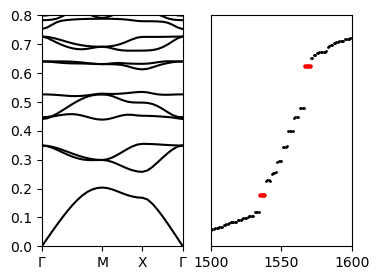

(Any[], Any[])

In [260]:
figure(figsize=(4, 3))
subplot(1, 2, 1)
plot(bulk_dispersion, color="black")
ylim(0, 0.8)
xticks([0, 12, 20, 28], ["Γ", "M", "X", "Γ"])
xlim(0, 28)
subplot(1, 2, 2)
scatter(1:2048, bands_c4, s=1, color="black")
scatter(1535:1538, bands_c4[1535:1538], s=5, color="red")
scatter(1567:1570, bands_c4[1567:1570], s=5, color="red")
ylim(0.53, 0.63)
xlim(1500, 1600)
yticks([])


In [262]:
brs = bandreps(sgnum, D)
n_bulk = cumsummariesv[3797][5].n
brs_decomp = decompose(n_bulk, brs)
brs_labs = ["(" * br.wyckpos * "|"  * prod(string.(collect(br.label)[1:end-2])) * ")" for br in brs]
println("BandRep decomposition: ", Crystalline.symvec2string(brs_decomp, brs_labs));

BandRep decomposition: [(2c|A)+(2c|B)+(1b|A)+(1b|B)]


In [263]:
# So we clearly see that we have a corner charge of 0.5 and no polarization. And if we reposition to (0.5, 0.5), we have 
# no corner charge and no polarization

In [264]:
sg_dir = "output/sg$sgnum/"
dir_list = readdir(non_sg2_dir * sg_dir);
collate_filename = "sg$(sgnum)-pwrs-and-epsilon.h5";
collate_h5 = h5open(non_sg2_dir * sg_dir * collate_filename);

In [268]:
Rs_from_h5 = read(collate_h5, "epsilon/lattice vectors");
println("Lattice vectors from mpi-enabled corner charge calculation: ")
round.(Rs_from_h5, digits=3)

Lattice vectors from mpi-enabled corner charge calculation: 


3×3 Matrix{Float64}:
  0.0  16.0  0.0
 16.0   0.0  0.0
  0.0   0.0  1.0

In [269]:
original_epsilon_dir = "./symeigs/output/sg$(sgnum)/eps1/te/"
#original_epsilon_filename = "sg$(sgnum)-eps1-epsilon.h5";
input_filename = "sg$(sgnum)-epsid1-res64-te-input.jld2"
#original_epsilons = h5open(original_epsilon_dir * original_epsilon_filename);
loaded_input = load(original_epsilon_dir * input_filename);
Rsv, flatv, isovalv = loaded_input["Rsv"], loaded_input["flatv"], loaded_input["isovalv"];
Rs, flat, isoval = [x[3797] for x in [Rsv, flatv, isovalv]];
#original_epsilon = read(original_epsilons, "sg10/3797/epsilon");

In [270]:
pwrs = Matrix{Float64}[]
for band in 1535:1538 
    pwr = read(collate_h5, "pwrs/band$(band)/data")
    push!(pwrs, pwr)
end
pwrs = Matrix{Float64}[]
for band in 1567:1570 
    pwr = read(collate_h5, "pwrs/band$(band)/data")
    push!(pwrs, pwr)
end

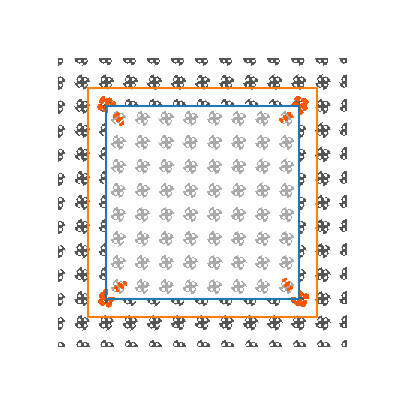

In [271]:
xyz = range(-8, 8, length=256)
supercell = 8 
Rsprime = [Rs[2], Rs[1]] # Note that Rs are switched in the corner charge calculation since it uses MPI
X = broadcast((x,y) -> (x)*Rsprime[1][1] + (y)*Rsprime[2][1], reshape(xyz,(1, 256)), reshape(xyz, (256, 1)))
Y = broadcast((x,y) -> (x)*Rsprime[1][2] + (y)*Rsprime[2][2], reshape(xyz,(1, 256)), reshape(xyz, (256, 1)));

fig = figure(figsize=(5, 5))

contour_data = sum(pwrs)
max_data = maximum(contour_data)
wigner_cell = wignerseitz(Rs)

min_range = -6
max_range = 6
resolution = 600
relative_shift = 1/2*resolution/(max_range-min_range) # (1/2, 1/2) shift of the unit cell regardless of resolution
relative_shift = Int(round(relative_shift))*[1, 1]

supercell_plot(flat, flat, Rs, wigner_cell, isoval, isoval, fig=fig, ax=gca(), 
    xyz=range(min_range, max_range, length=resolution), supercell=supercell, plot_boundary=true, relative_shift=relative_shift)
contourf(X, Y, contour_data, alpha=1, levels=(max_data/10, max_data), cmap=plt.get_cmap("hot", 100))
gca().set_aspect("equal", adjustable="box")

c = Brillouin.cartesianize(wigner_cell)
cxs, cys = getindex.(c[1]*(supercell+1.5), 1), getindex.(c[1]*(supercell+1.5), 2)

push!(cxs, cxs[1]); push!(cys, cys[1])
gca().plot(cxs, cys);  # plot unit cell

# Plane group 2

In [404]:
sgnum = 2; id_eps=3; mode="te"
dispersion_dir = "./dispersions/output/sg$(sgnum)/eps$(id_eps)/$mode/";
loaded_dispersion_data = load(dispersion_dir*"sg$(sgnum)-epsid$(id_eps)-res64-$mode.jld2")
marginsv = loaded_dispersion_data["marginsv"];
cumsummariesv = loaded_dispersion_data["cumsummariesv"];
dispersionsv = loaded_dispersion_data["dispersionsv"];
brs = bandreps(sgnum, D);

In [405]:
n_bulk = cumsummariesv[9558][3].n
brs_decomp = decompose(n_bulk, brs)
brs_labs = ["(" * br.wyckpos * "|"  * prod(string.(collect(br.label)[1:end-2])) * ")" for br in brs]
println("BandRep decomposition: ", Crystalline.symvec2string(brs_decomp, brs_labs));
# Polarization of this will be (0, 0) and corner charge will be 0.5 if we shift by (0, 1/2) since it'll be [(1c|A)+(1d|A)+(1b|A)]

BandRep decomposition: [(1d|A)+(1c|A)+(1a|A)]


In [406]:
n_clad = cumsummariesv[1877][3].n
brs_decomp = decompose(n_clad, brs)
brs_labs = ["(" * br.wyckpos * "|"  * prod(string.(collect(br.label)[1:end-2])) * ")" for br in brs]
println("BandRep decomposition: ", Crystalline.symvec2string(brs_decomp, brs_labs));
# This has no polarization and no corner charge

BandRep decomposition: [(1d|A)+(1d|B)+(1a|A)]


In [407]:
# Load the unit cells
# We again use eps_id = 3
sgnum = 2
input_dir = "./symeigs/output/sg$(sgnum)/eps1/te/"
input_filename = "sg$(sgnum)-epsid1-res64-te-input.jld2"
loaded_input = load(input_dir * input_filename)
supercell = 6
Rsv, flatv, isovalv = loaded_input["Rsv"], loaded_input["flatv"], loaded_input["isovalv"]
Rs, flat_bulk, isoval_bulk = Rsv[9558], flatv[9558], isovalv[9558]
flat_clad, isoval_clad, = flatv[1877], isovalv[1877];
vert_idxs = [5, 6, 1, 2];

In [408]:
# For plane group 2, we change one of the lattices so it is commensurate with the bulk. So we first check that the band structure doesn't change much
log_dispersion_dir = "./corner_charge_supercells_sg2/dispersions/logs/"
log_filename = "dim2-sg2-21877-res64-te.log"
io = open(log_dispersion_dir * log_filename)
log_str = read(io, String)
close(io)
bands_c2 = logs_to_dispersion(log_str)
io = IOBuffer(bands_c2)
bands_c2 = readdlm(io, ',')[:, 6:end];

In [411]:
# We also check that the symmetry eigenvalues don't change
log_symeigs_dir = "./corner_charge_supercells_sg2/symeigs/logs/"
log_filename = "dim2-sg2-21877-res64-te.log"
io = open(log_symeigs_dir * log_filename)
log_str = read(io, String)
io = IOBuffer(log_str)
include("./symeigs-from-io.jl")
symeigsd, lgd = _read_symdata(io, sgnum, Val(D))
summaries = analyze_symmetry_data(symeigsd, pick_lgirreps(lgd), brs)
cum_summaries = cumsum(summaries);

In [419]:
[cumsummariesv[1877][i].n - cum_summaries[i].n for i in 1:20]

20-element Vector{Vector{Int64}}:
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, -1, 1, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 1, -1, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0]

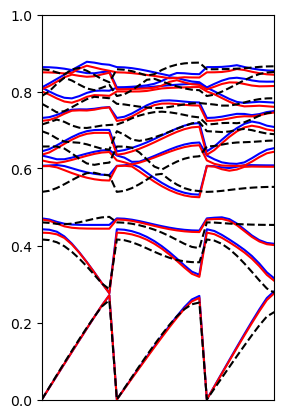

In [305]:
figure(figsize=(3, 5))
plot(bands_c2, color="blue")
plot(dispersionsv[1877][:, 1:10], color="red")
plot(dispersionsv[9558][:, 1:10], color="black", linestyle="dashed")

xlim(0, 31)
xticks([])
ylim(0, 1);

In [306]:
log_dir = "./corner_charge_supercells_sg2/supercell_calcs/logs/"
log_filename = "dim2-sg2-29558-res16-te-supercell-corner.log"
io = open(log_dir * log_filename)
log_str = read(io, String)
close(io)
bands_c2 = logs_to_dispersion(log_str)
io = IOBuffer(bands_c2)
bands_c2 = readdlm(io, ',')[:, 6:end];

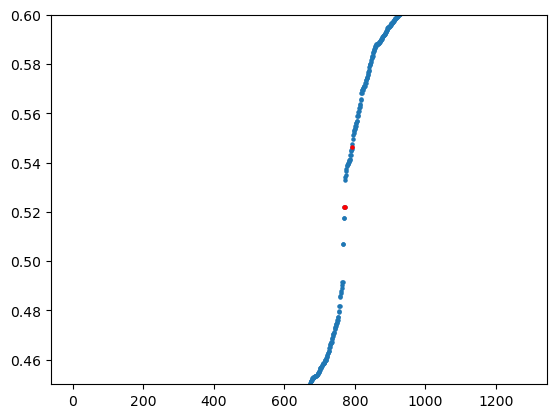

PyObject <matplotlib.collections.PathCollection object at 0x7f59441cf580>

In [312]:
scatter(1:1280, bands_c2, s =5)
ylim(0.45,0.6)
#xlim(760, 780)
scatter([770, 771, 792], bands_c2[[770, 771, 792]], s =5, color="red")
#ylim(0.475, 0.525)
#xlim(750, 800)
#ylim(0.4, 0.6)

In [313]:
collate_filename = "sg$(sgnum)-pwrs-and-epsilon.h5";
collate_h5 = h5open(sg2_output_dir * collate_filename);
epsilon = read(collate_h5, "epsilon/data");
epsilon_new = read(collate_h5, "epsilon/data-new");

In [314]:
Rs_from_h5 = read(collate_h5, "epsilon/lattice vectors")

3×3 Matrix{Float64}:
 7.67807  16.0  0.0
 9.88535   0.0  0.0
 0.0       0.0  1.0

In [315]:
pwrs = []
pwrs_new = []
for band in [770:772..., 792]
    pwr = read(collate_h5, "pwrs/band$(band)/data")
    pwr_new = read(collate_h5, "pwrs/band$(band)/data-new") 
    push!(pwrs, pwr)
    push!(pwrs_new, pwr_new)
end

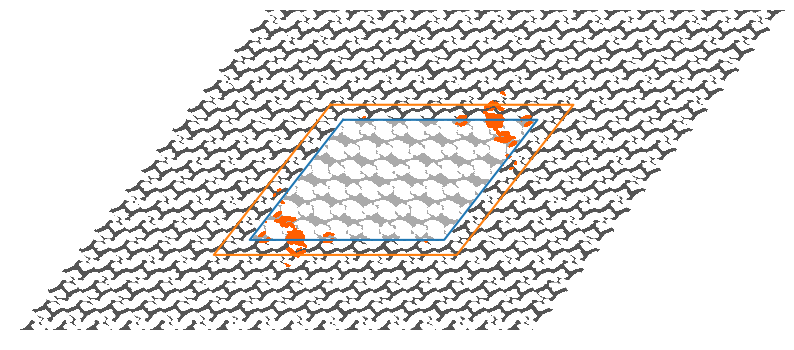

In [317]:
fig_dir = "../Fig3_Supercell_Figs/"

xyz = range(-8, 8, length=256)

Rsprime = [Rs[2], Rs[1]]
X = broadcast((x,y) -> (x)*Rsprime[1][1] + (y)*Rsprime[2][1], reshape(xyz,(1, 256)), reshape(xyz, (256,1)))
Y = broadcast((x,y) -> (x)*Rsprime[1][2] + (y)*Rsprime[2][2], reshape(xyz,(1, 256)), reshape(xyz, (256,1)));

fig = figure(figsize=(10, 10))

contour_data = pwrs[end]
max_data = maximum(contour_data)
wigner_cell = wignerseitz(Rs)
new_cell = Cell([SVector{2}([-0.5, -0.5]), SVector{2}([0.5, -0.5]), SVector{2}([0.5, 0.5]), SVector{2}([-0.5, 0.5]), SVector{2}([1., 0.]), SVector{2}([1., 0.])], wigner_cell.faces, wigner_cell.basis, wigner_cell.setting)

min_range = -8
max_range = 8
resolution = 300
relative_shift = 1/2*resolution/(max_range-min_range)
relative_shift = Int(round(relative_shift))*[0, 1]
supercell_plot(flat_bulk, flat_clad, Rs, new_cell, isoval_bulk, isoval_clad, fig=fig, ax=gca(), 
    xyz=range(min_range, max_range, length=resolution), translation_vector=[0, 0.5], supercell=supercell, plot_boundary=true, relative_shift=relative_shift, vert_idxs=vert_idxs)
contourf(X, Y, contour_data, alpha=1, levels=(max_data/25, max_data), cmap=plt.get_cmap("hot", 100))

gca().set_aspect("equal", adjustable="box")
#xlim(-7, 7)
#ylim(-7, 7)

c = Brillouin.cartesianize(new_cell)
cxs, cys = getindex.(c[1][vert_idxs]*(supercell+1.5), 1), getindex.(c[1][vert_idxs]*(supercell+1.5), 2)

push!(cxs, cxs[1]); push!(cys, cys[1])

gca().plot(cxs, cys)  # plot unit cell
gca().set_aspect("equal")
#savefig(fig_dir*"Figure3-sg2-corner-nopolarization.pdf")


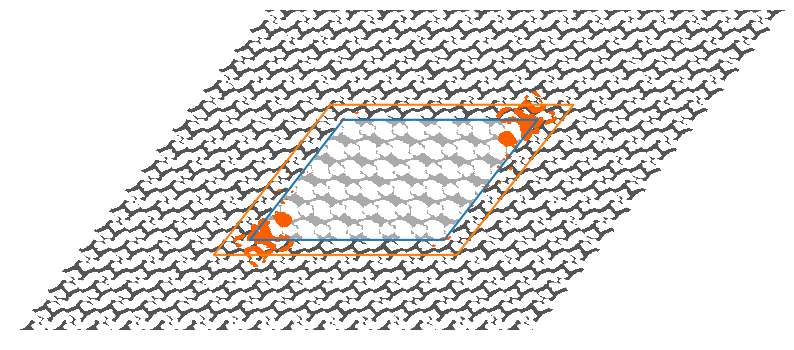

In [318]:
fig_dir = "../Fig3_Supercell_Figs/"

xyz = range(-8, 8, length=256)

Rsprime = [Rs[2], Rs[1]]
X = broadcast((x,y) -> (x)*Rsprime[1][1] + (y)*Rsprime[2][1], reshape(xyz,(1, 256)), reshape(xyz, (256,1)))
Y = broadcast((x,y) -> (x)*Rsprime[1][2] + (y)*Rsprime[2][2], reshape(xyz,(1, 256)), reshape(xyz, (256,1)));

fig = figure(figsize=(10, 10))

contour_data = sum(pwrs[1:2])
max_data = maximum(contour_data)
wigner_cell = wignerseitz(Rs)
new_cell = Cell([SVector{2}([-0.5, -0.5]), SVector{2}([0.5, -0.5]), SVector{2}([0.5, 0.5]), SVector{2}([-0.5, 0.5]), SVector{2}([1., 0.]), SVector{2}([1., 0.])], wigner_cell.faces, wigner_cell.basis, wigner_cell.setting)

min_range = -8
max_range = 8
resolution = 300
relative_shift = 1/2*resolution/(max_range-min_range)
relative_shift = Int(round(relative_shift))*[0, 1]
supercell_plot(flat_bulk, flat_clad, Rs, new_cell, isoval_bulk, isoval_clad, fig=fig, ax=gca(), 
    xyz=range(min_range, max_range, length=resolution), translation_vector=[0, 0.5], supercell=supercell, plot_boundary=true, relative_shift=relative_shift, vert_idxs=vert_idxs)
contourf(X, Y, contour_data, alpha=1, levels=(max_data/25, max_data), cmap=plt.get_cmap("hot", 100))

gca().set_aspect("equal", adjustable="box")
#xlim(-7, 7)
#ylim(-7, 7)

c = Brillouin.cartesianize(new_cell)
cxs, cys = getindex.(c[1][vert_idxs]*(supercell+1.5), 1), getindex.(c[1][vert_idxs]*(supercell+1.5), 2)

push!(cxs, cxs[1]); push!(cys, cys[1])

gca().plot(cxs, cys)  # plot unit cell
gca().set_aspect("equal")
#savefig(fig_dir*"Figure3-sg2-corner-nopolarization.pdf")

# Plane group 13

In [322]:
# The ids are 23510 and 29000 for the bulk and the cladding, respectively. 
# We again use epsid = 3
sgnum = 13
sg_dir = "output/sg$sgnum/"
dir_list = readdir(non_sg2_dir * sg_dir);
collate_filename = "sg$(sgnum)-pwrs-and-epsilon.h5";
collate_h5 = h5open(non_sg2_dir * sg_dir * collate_filename);

In [324]:
id_eps=3; mode="te"
dispersion_dir = "./dispersions/output/sg$(sgnum)/eps$(id_eps)/$mode/";
loaded_dispersion_data = load(dispersion_dir*"sg$(sgnum)-epsid$(id_eps)-res64-$mode.jld2")
marginsv = loaded_dispersion_data["marginsv"];
cumsummariesv = loaded_dispersion_data["cumsummariesv"];
dispersionsv = loaded_dispersion_data["dispersionsv"];

In [328]:
brs = bandreps(13, 2)
n_clad = cumsummariesv[9000][3].n
n_bulk = cumsummariesv[3510][3].n

brs_decomp = decompose(n_bulk, brs)
brs_labs = ["(" * br.wyckpos * "|"  * prod(string.(collect(br.label)[1:end-2])) * ")" for br in brs]
println("BandRep decomposition: ", Crystalline.symvec2string(brs_decomp, brs_labs));

brs_decomp = decompose(n_clad, brs)
brs_labs = ["(" * br.wyckpos * "|"  * prod(string.(collect(br.label)[1:end-2])) * ")" for br in brs]
println("BandRep decomposition: ", Crystalline.symvec2string(brs_decomp, brs_labs));

# As we can see above, the clad and bulk have no polarization and the bulk has a non-zero corner charge

BandRep decomposition: [(1c|A)+(1b|A)+(1a|A)]
BandRep decomposition: [(1c|A)+(1c|E)+(1a|A)]


In [329]:
log_dir = "./corner_charge_supercells/logs/"
log_filename = "dim2-sg13-23510-res64-te-supercell-corner.log"
io = open(log_dir * log_filename)
log_str = read(io, String)
close(io)
bands_c3 = logs_to_dispersion(log_str)
io = IOBuffer(bands_c3)
bands_c3 = readdlm(io, ',')[:, 6:end];

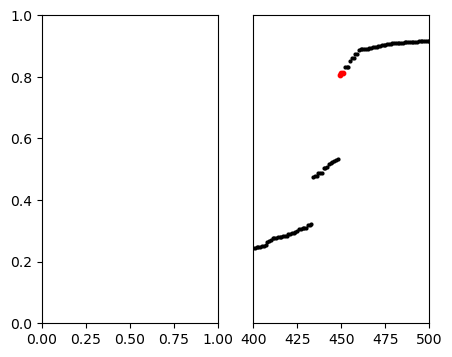

(Any[], Any[])

In [330]:
figure(figsize=(5, 4))
subplot(1, 2, 1)
subplot(1, 2, 2)
scatter(1:720, bands_c3[1, :], s=4, color="black")
scatter(449:451, bands_c3[1, 449:451], s=10, color="red")

ylim(0.4, 0.7)
xlim(400, 500)
yticks([])

In [331]:
original_epsilon_dir = "./symeigs/output/sg$(sgnum)/eps1/te/"
original_epsilon_filename = "sg$(sgnum)-eps1-epsilon.h5";
input_filename = "sg$(sgnum)-epsid1-res64-te-input.jld2"
original_epsilons = h5open(original_epsilon_dir * original_epsilon_filename);
loaded_input = load(original_epsilon_dir * input_filename);
Rsv, flatv, isovalv = loaded_input["Rsv"], loaded_input["flatv"], loaded_input["isovalv"];

In [332]:
Rs_from_h5 = read(collate_h5, "epsilon/lattice vectors")

3×3 Matrix{Float64}:
 -6.0     12.0  0.0
 10.3923   0.0  0.0
  0.0      0.0  1.0

In [333]:
Rs_bulk, flat_bulk, isoval_bulk = [x[3510] for x in [Rsv, flatv, isovalv]];
Rs_clad, flat_clad, isoval_clad = [x[9000] for x in [Rsv, flatv, isovalv]];

In [334]:
original_epsilon_bulk = read(original_epsilons, "sg$(sgnum)/3510/epsilon");
original_epsilon_clad = read(original_epsilons, "sg$(sgnum)/9000/epsilon");

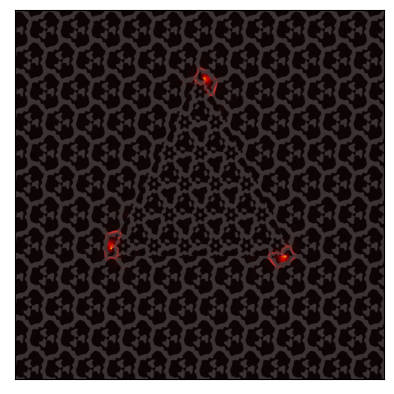

In [335]:
epsilon_new = read(collate_h5, "epsilon/data-new")

figure()
imshow(epsilon_new, alpha=0.9, cmap="gray")
pwrs = Matrix{Float64}[]
pwrs_new = Matrix{Float64}[]

for band in 449:451 
    pwr = read(collate_h5, "pwrs/band$(band)/data")
    pwr_new = read(collate_h5, "pwrs/band$(band)/data-new")
    push!(pwrs, pwr)
    push!(pwrs_new, pwr_new)
end
imshow(sum(pwrs_new), cmap="hot", alpha=0.8)
xticks([])
yticks([]);

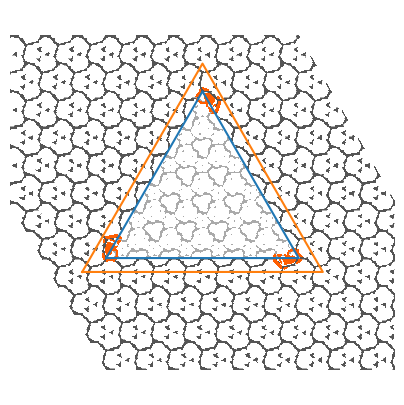

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f594da8e7c0>

In [336]:
vert_idxs = collect(2:2:6)
supercell = 6
fig_dir = "./Fig3_Supercell_Figs/"
resolution = 300
xyz = range(-6, 6, length=768)

Rsprime = [Rs_bulk[2], Rs_bulk[1]]
X = broadcast((x,y) -> (x)*Rsprime[1][1] + (y)*Rsprime[2][1], reshape(xyz,(1, 768)), reshape(xyz, (768,1)))
Y = broadcast((x,y) -> (x)*Rsprime[1][2] + (y)*Rsprime[2][2], reshape(xyz,(1, 768)), reshape(xyz, (768,1)));

fig = figure(figsize=(5, 5))

contour_data = sum(pwrs)
max_data = maximum(contour_data)
wigner_cell = wignerseitz(Rs_bulk)
supercell_plot(flat_bulk, flat_clad, Rs_bulk, wigner_cell, isoval_bulk, isoval_clad, fig=fig, ax=gca(), 
    xyz=range(-6, 6, length=resolution), supercell=supercell, plot_boundary=true, vert_idxs=vert_idxs)
contourf(X, Y, contour_data, alpha=1, levels=(max_data/10, max_data), cmap=plt.get_cmap("hot", 100))
gca().set_aspect("equal", adjustable="box")
xlim(-6, 6)
ylim(-6, 6)

c = Brillouin.cartesianize(wigner_cell)
cxs, cys = getindex.(c[1][vert_idxs]*(supercell+1.5), 1), getindex.(c[1][vert_idxs]*(supercell+1.5), 2)

push!(cxs, cxs[1]); push!(cys, cys[1])

gca().plot(cxs, cys)  # plot unit cell

#savefig(fig_dir*"Figure3-sg13-corner.pdf")


# Plane group 16

In [337]:
sgnum = 16; id_eps=3; mode="te"
dispersion_dir = "./dispersions/output/sg$(sgnum)/eps$(id_eps)/$(mode)/";
filename = "sg$(sgnum)-epsid$(id_eps)-res64-$(mode).jld2"
loaded_dispersion_data = load(dispersion_dir*filename)
marginsv = loaded_dispersion_data["marginsv"];
cumsummariesv = loaded_dispersion_data["cumsummariesv"];
dispersionsv = loaded_dispersion_data["dispersionsv"];

In [338]:
clad_dispersion = dispersionsv[275]
bulk_dispersion = dispersionsv[8080];
clad_summaries = cumsummariesv[275]
bulk_summaries = cumsummariesv[8080];

In [339]:
brs = bandreps(sgnum, 2);
brs_labs = ["(" * br.wyckpos * "|"  * prod(string.(collect(br.label)[1:end-2])) * ")" for br in brs]

n_bulk = cumsummariesv[8080][3].n;
n_clad = cumsummariesv[275][1].n;
bulk_ebr_decomposition = decompose(n_bulk, brs)
clad_ebr_decomposition = decompose(n_clad, brs);

println("Bulk crystal EBR decomposition is: ", Crystalline.symvec2string(bulk_ebr_decomposition, brs_labs))
println("Clad crystal EBR decomposition is: ", Crystalline.symvec2string(clad_ebr_decomposition, brs_labs))

Bulk crystal EBR decomposition is: [(2b|A)+(1a|A)+(1a|E₂)]
Clad crystal EBR decomposition is: [(1a|A)]


In [340]:
log_dir = "./corner_charge_supercells/logs/"
log_filename = "dim2-sg16-28080-res16-te-supercell-corner.log"

io = open(log_dir * log_filename)
log_str = read(io, String)
close(io)
bands_c6 = logs_to_dispersion(log_str)
io = IOBuffer(bands_c6)
bands_c6 = readdlm(io, ',')[:, 6:end]

1×1024 Matrix{Float64}:
 0.0  0.0399187  0.0399883  0.040116  …  0.763161  0.76327  0.763426

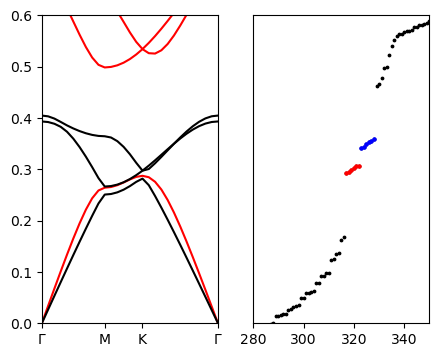

(Any[], Any[])

In [341]:
figure(figsize=(5, 4))
subplot(1, 2, 1)
plot(clad_dispersion, color="red")
plot(bulk_dispersion, color="black")
xticks([0, 10, 16, 28], ["Γ", "M", "K", "Γ"])
ylim(0, 0.6)
xlim(0, 28)
subplot(1, 2, 2)
scatter(1:1024, bands_c6, s=3, color="black")
scatter(317:322, bands_c6[317:322],color="red", s=5)
scatter(323:328, bands_c6[323:328],color="blue", s=5)

xlim(280, 350)
ylim(0.35, 0.5)
yticks([])

In [342]:
# So we see we have no polarization/corner charge for the cladding and a corner charge of 0.5 for the bulk

In [343]:
sg_dir = "output/sg$sgnum/"
dir_list = readdir(non_sg2_dir * sg_dir);
collate_filename = "sg$(sgnum)-pwrs-and-epsilon.h5";
collate_h5 = h5open(non_sg2_dir * sg_dir * collate_filename);

In [344]:
original_epsilon_dir = "./symeigs/output/sg$(sgnum)/eps1/te/"
original_epsilon_filename = "sg$(sgnum)-eps1-epsilon.h5";
input_filename = "sg$(sgnum)-epsid1-res64-te-input.jld2"
original_epsilons = h5open(original_epsilon_dir * original_epsilon_filename);
loaded_input = load(original_epsilon_dir * input_filename);
Rsv, flatv, isovalv = loaded_input["Rsv"], loaded_input["flatv"], loaded_input["isovalv"];
Rs_bulk, flat_bulk, isoval_bulk = [x[8080] for x in [Rsv, flatv, isovalv]];
Rs_clad, flat_clad, isoval_clad = [x[275] for x in [Rsv, flatv, isovalv]];
Rs = Rs_bulk;

In [345]:
read(collate_h5, "epsilon/lattice vectors")

3×3 Matrix{Float64}:
 -8.0     16.0  0.0
 13.8564   0.0  0.0
  0.0      0.0  1.0

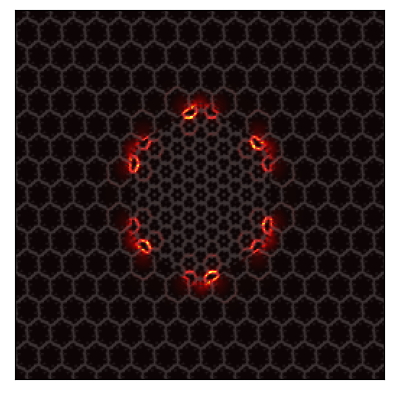

(Any[], Any[])

In [348]:
figure()
epsilon = read(collate_h5, "epsilon/data")
epsilon_new = read(collate_h5, "epsilon/data-new")

imshow(epsilon_new, alpha=0.9, cmap="gray")
pwrs = Matrix{Float64}[]
pwrs_new = Matrix{Float64}[]

for band in 317:322
    dir = "./corner_charge_supercells/output/sg16/"
    pwr_new = read(collate_h5, "pwrs/band$(band)/data-new")
    pwr = read(collate_h5, "pwrs/band$(band)/data")
    push!(pwrs, pwr)
    push!(pwrs_new, pwr_new)
end
imshow(sum(pwrs_new), cmap="hot", alpha=0.8)
gca().set_aspect("equal", adjustable="box")

xticks([])
yticks([])

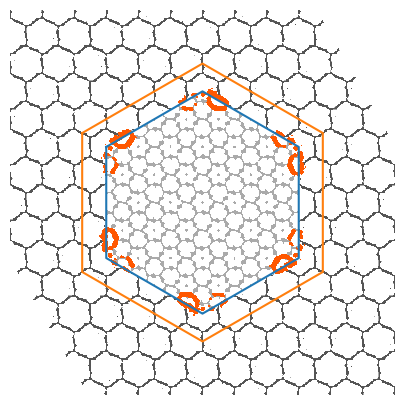

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f59315874c0>

In [350]:
fig = figure(figsize=(5, 5))
supercell = 6
resolution = 600

contour_data = sum(pwrs)
max_data = maximum(contour_data)
wigner_cell = wignerseitz(Rs)
xyz = range(-8, 8, length=256)
Rsprime = [Rs[1], Rs[2]]
X = broadcast((x,y) -> (x)*Rsprime[1][1] + (y)*Rsprime[2][1], reshape(xyz,(1,256)), reshape(xyz, (256,1)))
Y = broadcast((x,y) -> (x)*Rsprime[1][2] + (y)*Rsprime[2][2], reshape(xyz,(1,256)), reshape(xyz, (256,1)));

supercell_plot(flat_bulk, flat_clad, Rs, wigner_cell, isoval_bulk, isoval_clad, fig=fig, ax=gca(), 
    xyz=range(-7, 7, length=resolution), supercell=supercell, plot_boundary=true)
contourf(X, Y, contour_data, alpha=1, levels=(max_data/5, max_data), cmap=plt.get_cmap("hot", 100))
gca().set_aspect("equal", adjustable="box")
xlim(-6, 6)
ylim(-6, 6)

# Plot bigger boundary 

c = Brillouin.cartesianize(wigner_cell)
cxs, cys = getindex.(c[1]*(supercell+1.5), 1), getindex.(c[1]*(supercell+1.5), 2)

push!(cxs, cxs[1]); push!(cys, cys[1])

gca().plot(cxs, cys);  # plot unit cell


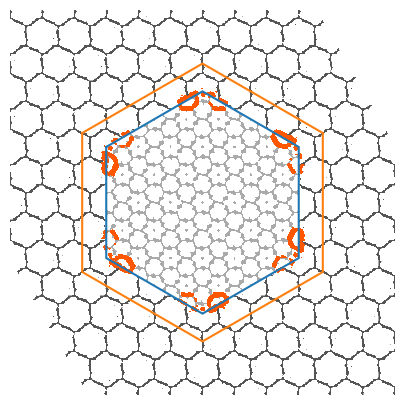

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5931377100>

In [351]:
fig = figure(figsize=(5, 5))
supercell = 6
resolution = 600

contour_data = sum(pwrs)
max_data = maximum(contour_data)
wigner_cell = wignerseitz(Rs)
xyz = range(-8, 8, length=256)
Rsprime = [Rs[1], Rs[2]]
X = broadcast((x,y) -> (x)*Rsprime[1][1] + (y)*Rsprime[2][1], reshape(xyz,(1,256)), reshape(xyz, (256,1)))
Y = broadcast((x,y) -> (x)*Rsprime[1][2] + (y)*Rsprime[2][2], reshape(xyz,(1,256)), reshape(xyz, (256,1)));

supercell_plot(flat_bulk, flat_clad, Rs, wigner_cell, isoval_bulk, isoval_clad, fig=fig, ax=gca(), 
    xyz=range(-7, 7, length=resolution), supercell=supercell, plot_boundary=true)
contourf(X, Y, transpose(contour_data), alpha=1, levels=(max_data/5, max_data), cmap=plt.get_cmap("hot", 100))
gca().set_aspect("equal", adjustable="box")
xlim(-6, 6)
ylim(-6, 6)

# Plot bigger boundary 

c = Brillouin.cartesianize(wigner_cell)
cxs, cys = getindex.(c[1]*(supercell+1.5), 1), getindex.(c[1]*(supercell+1.5), 2)

push!(cxs, cxs[1]); push!(cys, cys[1])

gca().plot(cxs, cys)  # plot unit cell